<a href="https://colab.research.google.com/github/vgandhi13/Stock_Prediction_using_RNN/blob/main/Stock_Prediction_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

Load Data

In [24]:
!pip install yfinance
import yfinance as yf
company = 'META'#Meta ticker symbol

start = dt.datetime(2012,1,1) #timepoint we want to start data from
end = dt.datetime(2020,1,1)

data = yf.download(company, start=start, end=end)  #we basically want this data for meta from yahoo finance api from specific start to end

[*********************100%***********************]  1 of 1 completed


Prepare Data for Neural Network

In [25]:
scaler = MinMaxScaler(feature_range=(0,1)) #Scale down all the values we have so that they fit between 0 and 1.Eg if one price is $0 and other is $100 we'll do such that all fit between 0 and 1

In [26]:
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1)) #not transform the whole data frame, only interested in the  closing price, because we are not interested in opening price or high price but just price after markets have closed

In [27]:
prediction_days = 60 #How many days in the past do I want  to based my prediction on, to predict what the price is gonna be next day

In [28]:
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):#start counting from 60 th index to last
    x_train.append(scaled_data[x-prediction_days:x, 0]) #we will append 60 values
    y_train.append(scaled_data[x, 0])

In [29]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # we are just adding 1 dimension here

Build Model

In [30]:
model = Sequential()

In [31]:
model.add(LSTM(units = 50, return_sequences = True, input_shape=(x_train.shape[1], 1))) #we are always going to add one LSTM layer, one dropout layer,one LSTM layer, one dropout layer, so on. In the end just one dense layer, which will be one unit which is the price . the more layers the longer it takes to train . you

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1)) #prediction of the next closing price

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 25, batch_size = 32) #MODEL IS gonna see same data 25 times, 32 units at once


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 174ms/step - loss: 0.0492
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0043
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0036
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0048
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0066
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0055
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0028
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0028
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0027
Epoch 10/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.0036
Epoch 11/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0032
Epoch 12/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0037
Epoch 13/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0030
Epoch 14/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.0030
Epoch 15/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 

In [33]:
''' Test the model accuracy on existing data '''

' Test the model accuracy on existing data '

Load Test Data

In [34]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yf.download(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values #cause we want to start as soon as possible
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)
#this is how we load data and now we need to predict based on the data we have not seen before and evaluate how it performs

[*********************100%***********************]  1 of 1 completed


Make predictions on test data

In [35]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])


x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


Plot the test Predictions

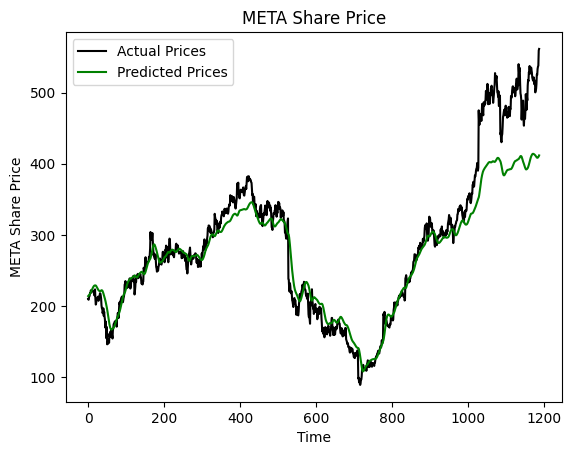

In [36]:
plt.plot(actual_prices, color = 'black', label = 'Actual Prices')
plt.plot(predicted_prices, color = 'green', label = 'Predicted Prices')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()


Predicting tomorrow/the next day

In [37]:
real_data = [model_inputs[len(model_inputs) + 1 -prediction_days: len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
